# AirBnB data feature engineering

## Notebook set-up

Assume we are preparing this data for a linear regression model.

In [1]:
# PyPI imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import power_transform, StandardScaler, SplineTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import RFECV

# Internal imports
import gperdrizet_functions as funcs

label='price'

features=[
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'neighbourhood_group',
    'room_type'
]

## 1. Data loading

In [2]:
raw_data_df=pd.read_parquet('../data/processed/gperdrizet_cleaned_data.parquet')
raw_data_df.dropna(inplace=True)
datasets={'Raw': raw_data_df.copy()}
raw_data_df.head().transpose()

,0,1,2,3,4
price,149.00000,225.00000,150.00000,89.00000,80.00000
latitude,40.64749,40.75362,40.80902,40.68514,40.79851
longitude,-73.97237,-73.98377,-73.94190,-73.95976,-73.94399
minimum_nights,1.00000,1.00000,3.00000,1.00000,10.00000
number_of_reviews,9.00000,45.00000,0.00000,270.00000,9.00000
reviews_per_month,0.21000,0.38000,0.28200,4.64000,0.10000
calculated_host_listings_count,6.00000,2.00000,1.00000,1.00000,1.00000
availability_365,365.00000,355.00000,365.00000,194.00000,0.00000
neighbourhood_group,1.00000,2.00000,2.00000,1.00000,2.00000
room_type,1.00000,0.00000,1.00000,0.00000,0.00000


In [3]:
raw_data_df.describe()

,price,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group,room_type
count,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000
mean,151.642648,40.728951,-73.952173,6.923259,23.273799,1.175985,7.145154,112.762741,1.675484,0.503938
std,206.700244,0.054533,0.046159,17.567191,44.553153,1.564368,32.957823,131.617456,0.735826,0.545282
min,10.000000,40.499790,-74.244420,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000
25%,69.000000,40.690095,-73.983075,1.000000,1.000000,0.144000,1.000000,0.000000,1.000000,0.000000
50%,106.000000,40.723080,-73.955680,3.000000,5.000000,0.536000,1.000000,45.000000,2.000000,0.000000
75%,175.000000,40.763120,-73.936285,5.000000,24.000000,1.650000,2.000000,227.000000,2.000000,1.000000
max,5000.000000,40.913060,-73.712990,500.000000,629.000000,58.500000,327.000000,365.000000,4.000000,2.000000


In [4]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48879 entries, 0 to 48878
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           48879 non-null  float64
 1   latitude                        48879 non-null  float64
 2   longitude                       48879 non-null  float64
 3   minimum_nights                  48879 non-null  float64
 4   number_of_reviews               48879 non-null  float64
 5   reviews_per_month               48879 non-null  float64
 6   calculated_host_listings_count  48879 non-null  float64
 7   availability_365                48879 non-null  float64
 8   neighbourhood_group             48879 non-null  int64  
 9   room_type                       48879 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 3.7 MB


## 2. Scaling & transformation methods

### 2.1. Box-Cox transformation

In [5]:
skewed_features=[
    'price',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'neighbourhood_group',
    'room_type'
]

transformed_data_df=raw_data_df.copy()
transformed_data_df[skewed_features]=power_transform(transformed_data_df[skewed_features]+1, method='box-cox')
datasets['Transformed']=transformed_data_df[features + [label]].copy()

transformed_data_df[features + [label]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48879 entries, 0 to 48878
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48879 non-null  float64
 1   longitude                       48879 non-null  float64
 2   minimum_nights                  48879 non-null  float64
 3   number_of_reviews               48879 non-null  float64
 4   reviews_per_month               48879 non-null  float64
 5   calculated_host_listings_count  48879 non-null  float64
 6   availability_365                48879 non-null  float64
 7   neighbourhood_group             48879 non-null  float64
 8   room_type                       48879 non-null  float64
 9   price                           48879 non-null  float64
dtypes: float64(10)
memory usage: 3.7 MB


### 2.2. Standard scaling

In [6]:
scaled_data_df=raw_data_df.copy()
scaler=StandardScaler()
scaled_data_df[features + [label]]=scaler.fit_transform(scaled_data_df[features + [label]])
datasets['Scaled']=scaled_data_df[features + [label]].copy()

scaled_data_df[features + [label]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48879 entries, 0 to 48878
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48879 non-null  float64
 1   longitude                       48879 non-null  float64
 2   minimum_nights                  48879 non-null  float64
 3   number_of_reviews               48879 non-null  float64
 4   reviews_per_month               48879 non-null  float64
 5   calculated_host_listings_count  48879 non-null  float64
 6   availability_365                48879 non-null  float64
 7   neighbourhood_group             48879 non-null  float64
 8   room_type                       48879 non-null  float64
 9   price                           48879 non-null  float64
dtypes: float64(10)
memory usage: 3.7 MB


### 2.3. Box-Cox transform + standard scaling

In [7]:
scaled_transformed_data_df=transformed_data_df.copy()
scaler=StandardScaler()
scaled_transformed_data_df[features + [label]]=scaler.fit_transform(scaled_transformed_data_df[features + [label]])
datasets['Transformed+scaled']=scaled_transformed_data_df[features + [label]].copy()

scaled_transformed_data_df[features + [label]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48879 entries, 0 to 48878
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48879 non-null  float64
 1   longitude                       48879 non-null  float64
 2   minimum_nights                  48879 non-null  float64
 3   number_of_reviews               48879 non-null  float64
 4   reviews_per_month               48879 non-null  float64
 5   calculated_host_listings_count  48879 non-null  float64
 6   availability_365                48879 non-null  float64
 7   neighbourhood_group             48879 non-null  float64
 8   room_type                       48879 non-null  float64
 9   price                           48879 non-null  float64
dtypes: float64(10)
memory usage: 3.7 MB


### 2.4. Results

#### 2.4.1. Linear model

In [8]:
linear_cross_val_results_df, linear_tukey_result=funcs.evaluate_datasets(
    LinearRegression(),
    datasets
)

ANOVA p-value: 0.000



#### 2.4.2. Tree model

In [9]:
tree_cross_val_results_df, tree_tukey_result=funcs.evaluate_datasets(
    HistGradientBoostingRegressor(),
    datasets
)

ANOVA p-value: 0.000



#### 2.4.2. Model comparison

Linear model:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1         group2       meandiff p-adj  lower  upper  reject
-------------------------------------------------------------------
        Raw             Scaled     -0.0   1.0 -0.0064 0.0064  False
        Raw        Transformed   0.3918   0.0  0.3855 0.3982   True
        Raw Transformed+scaled   0.3918   0.0  0.3855 0.3982   True
     Scaled        Transformed   0.3918   0.0  0.3855 0.3982   True
     Scaled Transformed+scaled   0.3918   0.0  0.3855 0.3982   True
Transformed Transformed+scaled     -0.0   1.0 -0.0064 0.0064  False
-------------------------------------------------------------------

Tree model:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1         group2       meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------
        Raw             Scaled   0.0038 0.8705 -0.0091 0.0167  False
        Raw    

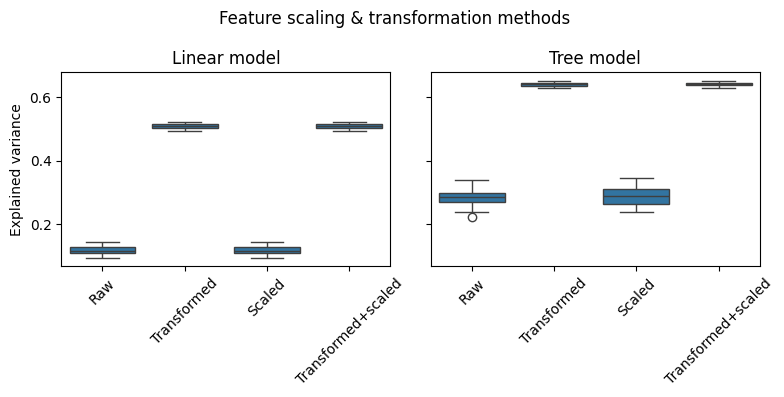

In [10]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs=plt.subplots(1,2, figsize=(8,4), sharey=True)
axs=axs.flatten()

fig.suptitle('Feature scaling & transformation methods')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

plt.tight_layout()
plt.show()

## 3. Synthetic features

In [11]:
features_df=datasets['Transformed'].copy()
synthetic_features={'Input': features_df}

### 3.1. Polynomial features

In [15]:
degrees=[2,3,4]

for degree in degrees:
    poly=PolynomialFeatures(degree=degree, include_bias=False)
    poly_features=poly.fit_transform(features_df.drop('price', axis=1))
    poly_features_df=pd.DataFrame(poly_features, columns=poly.get_feature_names_out())
    synthetic_features[f'Polynomial degree {degree}']=poly_features_df
    synthetic_features[f'Polynomial degree {degree}']['price']=features_df['price']

### 3.2. Spline features

In [18]:
knots=[2,3,4]

for degree in degrees:
    spline=SplineTransformer(degree=degree)
    spline_features=spline.fit_transform(features_df.drop('price', axis=1))
    spline_features_df=pd.DataFrame(spline_features, columns=spline.get_feature_names_out())
    synthetic_features[f'Spline degree {degree}']=spline_features_df
    synthetic_features[f'Spline degree {degree}']['price']=features_df['price']

### 3.3. Results

#### 3.3.1. Linear model

In [19]:
linear_cross_val_results_df, linear_tukey_result=funcs.evaluate_datasets(
    LinearRegression(),
    synthetic_features
)

ANOVA p-value: 0.000



#### 3.3.2. Tree model

In [20]:
tree_cross_val_results_df, tree_tukey_result=funcs.evaluate_datasets(
    HistGradientBoostingRegressor(),
    synthetic_features
)

ANOVA p-value: 0.009



#### 3.3.3. Results comparison

Linear model:

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
              Input Polynomial degree 2   0.0794    0.0   0.074  0.0848   True
              Input Polynomial degree 3   0.0988    0.0  0.0934  0.1042   True
              Input Polynomial degree 4   0.1049    0.0  0.0995  0.1103   True
              Input     Spline degree 2   0.0752    0.0  0.0698  0.0806   True
              Input     Spline degree 3   0.0785    0.0  0.0732  0.0839   True
              Input     Spline degree 4   0.0796    0.0  0.0742  0.0849   True
Polynomial degree 2 Polynomial degree 3   0.0194    0.0   0.014  0.0248   True
Polynomial degree 2 Polynomial degree 4   0.0255    0.0  0.0201  0.0309   True
Polynomial degree 2     Spline degree 2  -0.0042 0.2368 -0.0096  0.0012  False
Polynomial degree 2     Spline degree

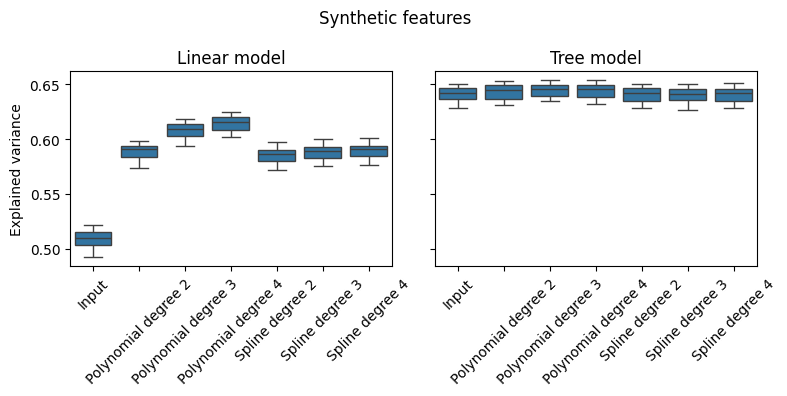

In [21]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs=plt.subplots(1,2, figsize=(8,4), sharey=True)
axs=axs.flatten()

fig.suptitle('Synthetic features')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

plt.tight_layout()
plt.show()

## 4. Feature selection

### 4.1. Recursive feature elimination

In [22]:
linear_selector=RFECV(
    LinearRegression(),
    step=1,
    cv=5,
    scoring='explained_variance',
    n_jobs=-1
)

linear_selector=linear_selector.fit(
    synthetic_features[f'Polynomial degree 3'].drop('price', axis=1), 
    synthetic_features[f'Polynomial degree 3']['price']
)

### 4.2. Results

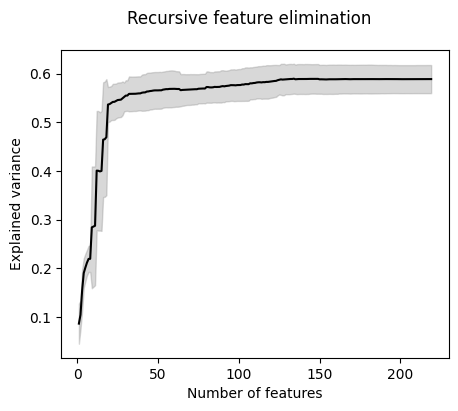

In [23]:
linear_results = pd.DataFrame(linear_selector.cv_results_)

fig, axs=plt.subplots(1,1, figsize=(5,4), sharey=True)

fig.suptitle('Recursive feature elimination')

axs.plot(linear_results['n_features'], linear_results['mean_test_score'], color='black')
axs.fill_between(
    linear_results['n_features'],
    linear_results['mean_test_score'] - linear_results['std_test_score'],
    linear_results['mean_test_score'] + linear_results['std_test_score'],
    color='grey',
    alpha=0.3
)
axs.set_xlabel('Number of features')
axs.set_ylabel('Explained variance')

fig.show()

## 5. Save final data

### 5.1. Select features

In [24]:
data_df=synthetic_features[f'Polynomial degree 3'][linear_selector.get_feature_names_out()].copy()

### 5.2. Write to disk

In [26]:
data_df.to_parquet('../data/processed/gperdrizet_processed_data.parquet')